In [1]:
"""\
This script contains all the functions used to run compartmentalization analyses in the paper
"Dynamics of microcompartment formation at the mitosis-to-G1 transition".

Example shows compartmentalization analyses for condensin depletion data (Fig. 4)

Uses cooltools: https://cooltools.readthedocs.io/en/latest/notebooks/compartments_and_saddles.html

Author: Viraat Goel
"""

# import standard python libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess

# import python package for working with cooler files and tools for analysis
import cooler
import cooltools.lib.plotting
from packaging import version
#if version.parse(cooltools.__version__) < version.parse('0.5.4'):
#    raise AssertionError("tutorials rely on cooltools version 0.5.4 or higher,"+
#                         "please check your cooltools version and update to the latest")

import cooltools

### Set global parameters

In [291]:
# parameters
res = 2000

#List of mcool conditions as strings
conditions = ["0h", "0.5h", "1h", "4h", "8h"]

#Lists of mcool and cis-expected files
clrFiles = []
expectedFiles = []

for condition in conditions:
    clrFiles.append('COOLER_FILES_DIRECTORY/RCMC_Condensin_'+condition+'_mm39.merged.50.mcool')
    expectedFiles.append('EXPECTED_FILES_DIRECTORY/Condensin_'+condition+'_'+str(res)+'bpRes_mm39.tsv')


#List of loop types as strings
loopTypesNames = ["P-P", "E-P", "E-E", "P-CTCF", "E-CTCF", "CTCF-CTCF", "P-other", "E-other", "CTCF-other", "other-other"]

#List of loop file locations (bedpe)
loopFiles = []

for loopType in loopTypesNames:
    loopFiles.append('LOOP_TYPES_DIRECTORY/'+loopType+'.bedpe')

    
#Specify the RCMC regions of the mcools to look at (format: chromosome (string), start (number), end (number), name of region (string))
regions = pd.DataFrame([['chr2',151920000,153000000,'Id1'],['chr8',84848000,85856000,'Klf1'],['chr8',122950000,124110000,'Cdt1'],['chr9',107100000,108600000,'Dag1'],['chr15',61810000,63684000,'Myc']], columns=['chrom', 'start', 'end', 'name'])

#Bounds for regions very slightly adjusted to be divisible by the res

### Read mcool and load in GC content

In [354]:
condition = '4h' # change to desired condition
clr = cooler.Cooler(f'{clrFiles[conditions.index(condition)]}::/resolutions/{res}') # change the index to reflect the condition

#Set save directory
saveDir = 'SAVE_DIRECTORY'

## fasta sequence is required for calculating binned profile of GC conent
if not os.path.isfile('PATH_TO_FA/mm39.fa'):
    ## note downloading a ~1Gb file can take a minute
    subprocess.call('wget --progress=bar:force:noscroll https://hgdownload.cse.ucsc.edu/goldenpath/mm39/bigZips/mm39.fa.gz', shell=True)
    subprocess.call('gunzip PATH_TO_FA.GZ/mm39.fa.gz', shell=True)
    
import bioframe
bins = clr.bins()[:]
mm39_genome = bioframe.load_fasta('PATH_TO_fa/mm39.fa');
## note the next command may require installing pysam
gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], mm39_genome)
gc_cov.to_csv('SAVE_DIRECTORY/mm39_gc_cov_' + str(res) + 'bp.tsv',index=False,sep='\t')
display(gc_cov)

/home/viraat/anaconda3/envs/newCoolTools/lib/python3.10/site-packages/bioframe/extras.py:312: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby("chrom", sort=False)[["start", "end"]].apply(_each)


chrom  start    end        GC
0        chr1      0   2000       NaN
1        chr1   2000   4000       NaN
2        chr1   4000   6000       NaN
3        chr1   6000   8000       NaN
4        chr1   8000  10000       NaN
...       ...    ...    ...       ...
1361722  chrM   8000  10000  0.362000
1361723  chrM  10000  12000  0.351500
1361724  chrM  12000  14000  0.377000
1361725  chrM  14000  16000  0.384000
1361726  chrM  16000  16299  0.331104

[1361727 rows x 4 columns]

### Calculate eigenvectors

In [ ]:
# obtain first 5 eigenvectors
cis_eigs = cooltools.eigs_cis(
                        clr,
                        gc_cov,
                        view_df=regions,
                        n_eigs=5,
                        )

# cis_eigs[0] returns eigenvalues, here we focus on eigenvectors
eigenvector_track = cis_eigs[1][['chrom','start','end','E1']]

### Filter for eigenvectors in captured ROIs

In [356]:
filtered_eigvecs = []
for i in range(len(regions.index)):
    region = regions.iloc[i].to_list()
    filtered_eigvec = eigenvector_track[(eigenvector_track['chrom'] == region[0]) & (eigenvector_track['start'] >= region[1]) & (eigenvector_track['end'] <= region[2])]
    filtered_eigvec.reset_index(drop=True, inplace=True)
    filtered_eigvecs.append(filtered_eigvec)
print(filtered_eigvecs)

[    chrom      start        end        E1
0    chr2  151920000  151922000  0.829163
1    chr2  151922000  151924000  0.824877
2    chr2  151924000  151926000  0.630016
3    chr2  151926000  151928000  0.566466
4    chr2  151928000  151930000  0.473779
..    ...        ...        ...       ...
535  chr2  152990000  152992000  0.015745
536  chr2  152992000  152994000 -0.169613
537  chr2  152994000  152996000 -0.351500
538  chr2  152996000  152998000 -0.795893
539  chr2  152998000  153000000 -1.097986

[540 rows x 4 columns],     chrom     start       end        E1
0    chr8  84848000  84850000 -0.411280
1    chr8  84850000  84852000 -0.383722
2    chr8  84852000  84854000 -0.394746
3    chr8  84854000  84856000 -0.413395
4    chr8  84856000  84858000 -0.427226
..    ...       ...       ...       ...
499  chr8  85846000  85848000 -0.578276
500  chr8  85848000  85850000 -0.736543
501  chr8  85850000  85852000 -0.728886
502  chr8  85852000  85854000       NaN
503  chr8  85854000  85856000 

### Plot eigenvectors next to contact maps for each ROI

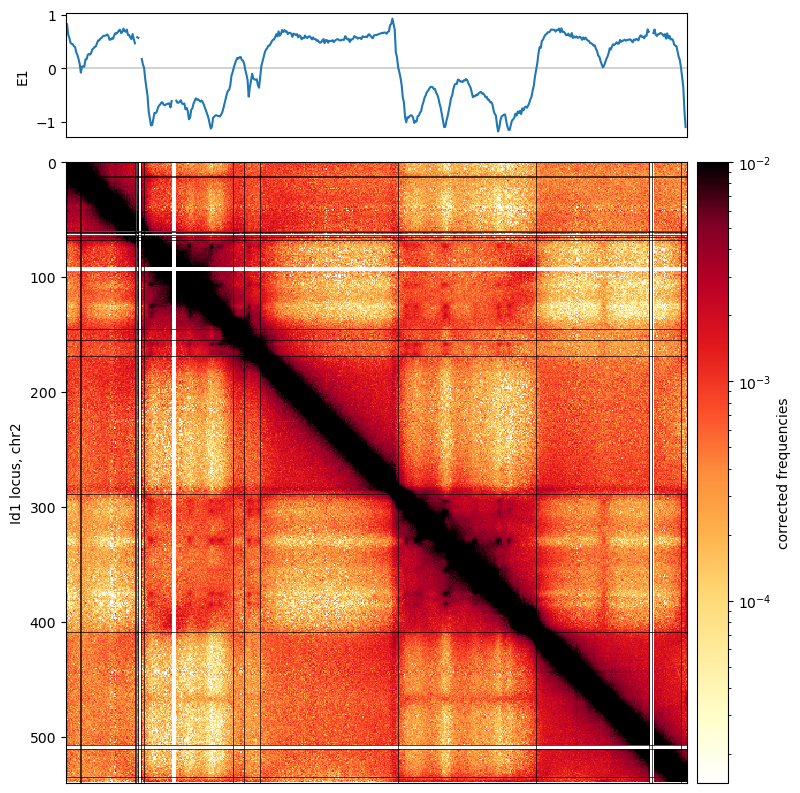

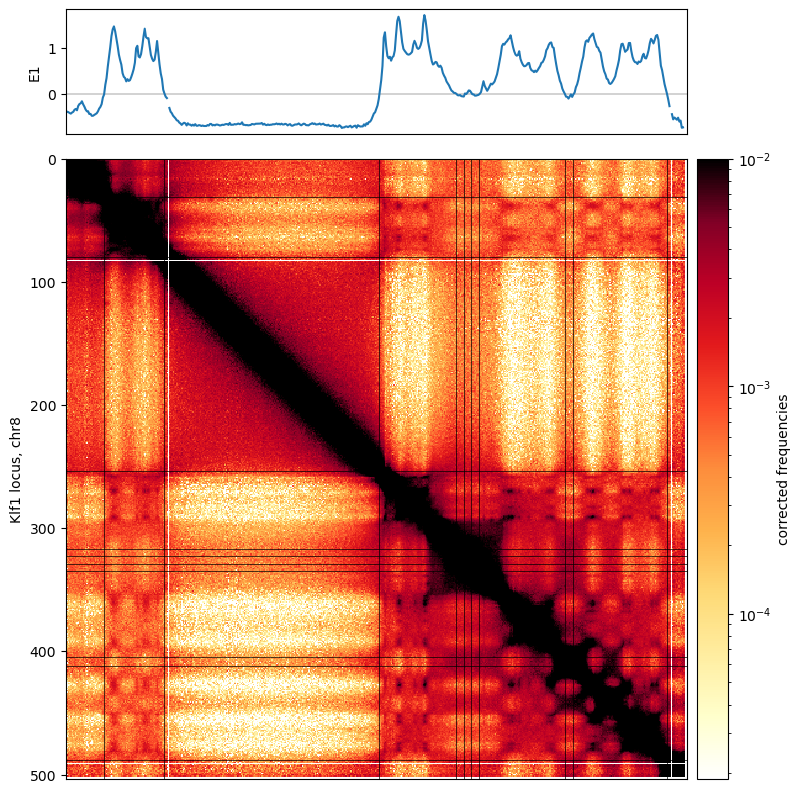

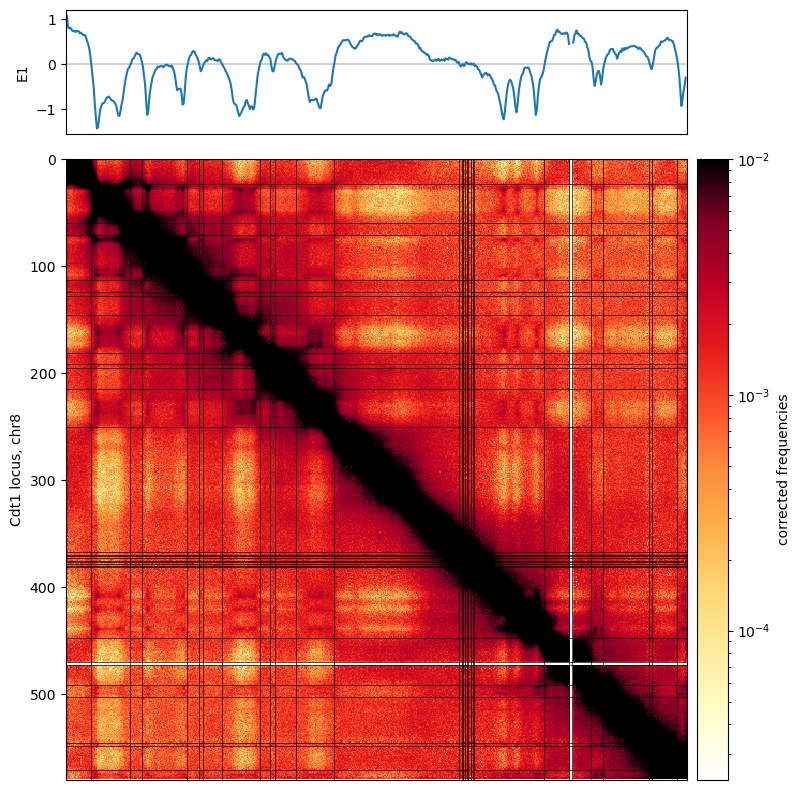

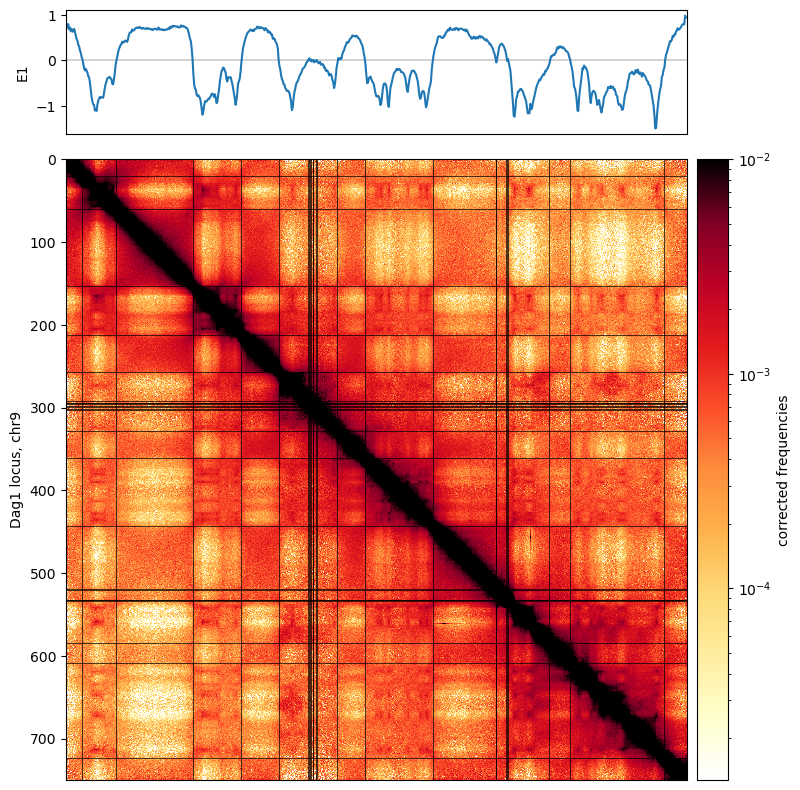

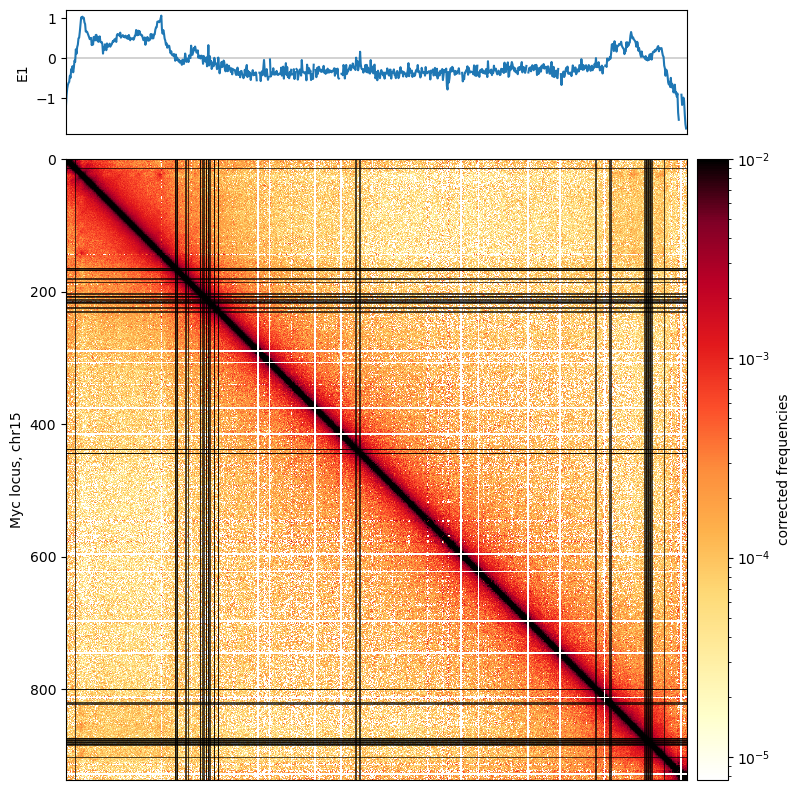

In [357]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

saveDir = 'SAVE_DIRECTORY'

for i in range(len(filtered_eigvecs)):
    data = filtered_eigvecs[i]
    binsInRegion = len(data.index)

    f, ax = plt.subplots(
        figsize=(15, 10),
    )

    norm = LogNorm(vmax=0.01) # 0.05 for 2kb res

    region = regions.iloc[i].to_list()[0] + ':' + str(regions.iloc[i].to_list()[1]) + '-' + str(regions.iloc[i].to_list()[2])
    name = regions.iloc[i].to_list()[3]

    im = ax.matshow(
        clr.matrix(balance=True).fetch(region),
        norm=norm,
        cmap='fall'
    );
    plt.axis([0,binsInRegion,binsInRegion,0])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, label='corrected frequencies');
    ax.set_ylabel(regions.iloc[i].to_list()[3] + ' locus, ' + regions.iloc[i].to_list()[0])
    ax.xaxis.set_visible(False)

    ax1 = divider.append_axes("top", size="20%", pad=0.25, sharex=ax)
    weights = clr.bins()[:]['weight'].values
    ax1.plot([0,binsInRegion],[0,0],'k',lw=0.25)
    ax1.plot(data['E1'].values, label='E1')

    ax1.set_ylabel('E1')
    ax1.set_xticks([]);

    for i in np.where(np.diff((data['E1']>0).astype(int)))[0]:
        ax.plot([0, binsInRegion],[i,i],'k',lw=0.5)
        ax.plot([i,i],[0, binsInRegion],'k',lw=0.5)

    f.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200)

# Saddle Plots

### Define global functions

In [358]:
saveDir = 'SAVE_DIRECTORY'

import warnings
from cytoolz import merge

def saddleplot(
    track,
    saddledata,
    n_bins,
    vrange=None,
    qrange=(0.0, 1.0),
    cmap="coolwarm",
    scale="log",
    vmin=0.5,
    vmax=2,
    color=None,
    title=None,
    xlabel=None,
    ylabel=None,
    clabel=None,
    fig=None,
    fig_kws=None,
    heatmap_kws=None,
    margin_kws=None,
    cbar_kws=None,
    subplot_spec=None,
):
    """
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

#     warnings.warn(
#         "Generating a saddleplot will be deprecated in future versions, "
#         + "please see https://github.com/open2c_examples for examples on how to plot saddles.",
#         DeprecationWarning,
#     )

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt

    class MinOneMaxFormatter(ticker.LogFormatter):
        def set_locs(self, locs=None):
            self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])

        def __call__(self, x, pos=None):
            if x not in [vmin, 1, vmax]:
                return ""
            else:
                return "{x:g}".format(x=x)

    track_value_col = track.columns[3]
    track_values = track[track_value_col].values

    digitized_track, binedges = cooltools.digitize(
        track, n_bins, vrange=vrange, qrange=qrange
    )
    x = digitized_track[digitized_track.columns[3]].values.astype(int).copy()
    x = x[(x > -1) & (x < len(binedges) + 1)]

    # Old version
    # hist = np.bincount(x, minlength=len(binedges) + 1)

    groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()

    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Barplot of mean values and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        groupmean = groupmean[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.2, 1, 0.1],
        height_ratios=[0.2, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
    elif scale == "linear":
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=1)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])

    plt.barh(
        binedges, height=1/len(binedges), width=groupmean, align="edge", **margin_kws
    )

    plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])

    plt.bar(
        binedges, width=1/len(binedges), height=groupmean, align="edge", **margin_kws
    )

    plt.xlim(lo, hi)
    # plt.ylim(plt.ylim())  # correct
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)

#     # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["ax_cbar"] = cb = plt.colorbar(img, **cbar_kws)
        # cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
        # # do linspace between vmin and vmax of 5 segments and trunc to 1 decimal:
        decimal = 10
        nsegments = 5
        cd_ticks = np.trunc(np.linspace(vmin, vmax, nsegments) * decimal) / decimal
        cb.set_ticks(cd_ticks)
    else:
        print('cbar')

        cb = plt.colorbar(img, format=MinOneMaxFormatter(), cax=grid["ax_cbar"], **cbar_kws)
        cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    grid['ax_heatmap'].grid(False)
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)
    
    fig.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200)

    return grid

### Calculate cis-expected

In [ ]:
cvd = cooltools.expected_cis(
        clr=clr,
        view_df=regions,
)

### Parameters for ignoring eigenvector extremes

In [360]:
Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each

### Generate saddleplot

In [ ]:
i = 1 # change this value to look at different regions

filtered_eigvec = filtered_eigvecs[i]
name = regions.iloc[i][3]

interaction_sum, interaction_count =  cooltools.saddle(
        clr,
        cvd,
        filtered_eigvec,
        contact_type='cis',
        n_bins=N_GROUPS,
        qrange=(Q_LO,Q_HI),
        view_df=regions
)

saddleplot(filtered_eigvecs[i],
           interaction_sum / interaction_count,
           N_GROUPS,
           qrange=(Q_LO,Q_HI),
           cbar_kws={'label':'average observed/expected contact frequency'}
          );

### Calculate saddleplot strength

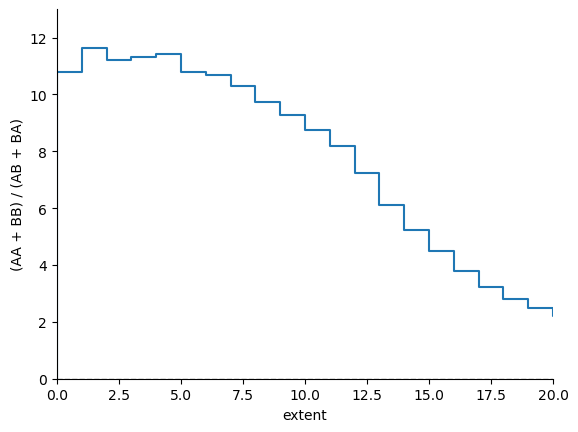

In [362]:
from cooltools.api.saddle import saddle_strength
# at extent=0, this reduces to ((S/C)[0,0] + (S/C)[-1,-1]) / (2*(S/C)[-1,0])

x = np.arange(N_GROUPS + 2)

plt.step(x, saddle_strength(interaction_sum, interaction_count), where='pre')

plt.xlabel('extent')
plt.ylabel('(AA + BB) / (AB + BA)')
#plt.title('saddle strength profile')
plt.axhline(0, c='grey', ls='--', lw=1) # Q: is there a reason this is 0 not 1?
plt.xlim(0, len(x)//2); # Q: is this less intuitive than showing for all x, as it converges to no difference (i.e. 1)?

ax = plt.gca()
right_side = ax.spines["right"]
top_side = ax.spines["top"]
right_side.set_visible(False)
top_side.set_visible(False)
ax.set_xlim([0,20]) # 12 for Dag1 & 20 for Klf1, 2kb res
ax.set_ylim([0,13]) # 12 for Dag1 & 13 for Klf1, 2kb res

plt.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200)